# MIR Task: Beatbox Dataset Evaluation Using Automatic Drum Transcription

According to [MIREX2018](https://www.music-ir.org/mirex/wiki/2018:Drum_Transcription), drum transcription is defined as the task of detecting the positions in time and labeling the drum class of drum instrument onsets in polyphonic music. The article *[A Review of Automatic Drum Transcription](https://ieeexplore.ieee.org/document/8350302)* offers an indebt explanation about automatic drum transcription as well as an extremely up to date state of the art.

The present task proposes to test and evaluate a [beatbox](https://archive.org/details/beatboxset1) dataset using an automatic drum transcription algorithm - [ADTLib](https://carlsouthall.files.wordpress.com/2017/12/ismir2017adt.pdf). 
To do so, a second dataset [ENST-Drums](http://www.tsi.telecom-paristech.fr/aao/en/2010/02/19/enst-drums-an-extensive-audio-visual-database-for-drum-signals-processing/) (used initially to develop ADTLib) will be used as a term of comparison.

Further conclusions about the beatbox dataset and it's elements will be made. 

This notebook requires the instalation of  **[ADTLib](https://github.com/CarlSouthall/ADTLib)** and **[mir_eval](https://github.com/craffel/mir_eval)**

In [1]:
import glob
import errno
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from IPython.display import display, Audio
import csv
from ADTLib import ADT
import mir_eval

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# 1) Beatboxset1

The [beatboxset1](https://archive.org/details/beatboxset1): beatboxing audio data set available in the Audio Content Analysis contains beatboxing recordings from various contributors, who recorded the clips themselves in various conditions. A spreadshit "beatboxset1.csv" accompanying the dataset that provides metadata for the recordings. Further annotations of the recordings are also included: these mark the positions of onsets as well as categorizing the events into a handful of standard classes.
 * k  = kick
 * hc = hihat, closed
 * ho = hihat, open
 * sb = snare, "bish" or "pss" -like
 * sk = snare, "k" -like  (may sound like a "clap" or "rimshot" snare)
 * s  = snare but not sure which of the above types (or isn't either of them)
 * br = a breath sound (not intended to sound like percussion)
 * m  = humming (or similar, a note with no drum-like or speech-like nature)
 * v  = speech or singing
 * x  = miscellaneous other sound (identifiable, but not fitting one of the other categories)
 * ?  = unsure of classification
 
In order to compare the handmade annotations and the output of the ADTLIB, the previous categorization will be reduce to three different categories: Kick, Snare and Hihat
 * Kick  = k
 * Snare = sb, sk, s
 * Hihat = hc,ho


In [51]:
dict_bb = {}
filenames = []
dataframes = []

#Function to delete sufix of a word
def strip_end(text, suffix):
    if not text.endswith(suffix):
        return text
    return text[:len(text)-len(suffix)] 

#Read beatbox1.cvs where all hand made annotations are
df = pd.read_csv('beatboxset1/beatboxset1.csv', sep=',', error_bad_lines=False, index_col=False, dtype='unicode')

for i , filename in enumerate(df.Filename):
    name = strip_end(filename, '.wav')
    df_temp = pd.read_csv('beatboxset1/Annotations_DR/' + name +'.csv', sep=',',header=None, dtype='unicode')
    dataframes.append(df_temp) 
    filenames.append(name)

In [52]:
#funtion that allows to read information inside dictionary
def get_nested(data, *args):
    if args and data:
        element  = args[0]
        if element:
            value = data.get(element)
            return value if len(args) == 1 else get_nested(value, *args[1:])
#beatbox dictionary creation
for i, filename in enumerate(filenames):
    dict_bb[filename] = {}
    dict_bb[filename]['Kick'] = []
    dict_bb[filename]['Snare'] = []
    dict_bb[filename]['Hihat'] = []

In [53]:
#Insert handmade kick annotations in the beatbox dictionary
for i, df in enumerate(dataframes):
    df1 = df[df[1].str.contains("k")] 
    indexNames = df1[df1[1]=='sk'].index
    df2 = df1.copy()
    df2.drop(indexNames, inplace=True)
    t = list(df2[0])
    t = np.asarray(t)
    dict_bb[filenames[i]]['Kick'] = t  

#Insert handmade Snare annotations in the beatbox dictionary
for i, df in enumerate(dataframes): 
    df1 = df[df[1].str.contains("s")] 
    t =list(df1[0])
    t = np.asarray(t)
    dict_bb[filenames[i]]['Snare'] = t 

#Insert handmade Hihat annotations in the beatbox dictionary
for i, df in enumerate(dataframes): 
    df1 = df[df[1].str.contains("h")] 
    t =list(df1[0])
    t = np.asarray(t)
    dict_bb[filenames[i]]['Hihat'] = t 

# 2) ENST-Drums

[ENST-Drums](http://biblio.telecom-paristech.fr/cgi-bin/download.cgi?id=6651) is a large and varied research database for automatic drum transcription and processing:

* Three professional drummers specialized in different music genres were recorded.

*  Total duration of audio material recorded per drummer is around 75 minutes.

* Each drummer played his own drum kit.

* Each sequence used either sticks, rods, brushes or mallets to increase the diversity of drum sounds.

* The drum kits themselves are varied, ranging from a small, portable, kit with two toms and 2 cymbals, suitable for jazz and latin music ; to a larger rock drum set with 4 toms and 5 cymbals.

(Missing description of the dataset)

* sweep = brush sweep
* sticks = Sticks hit together
* sd = snare drum
* rs = rim shot
* cs = cross stick
* chh = closed hihat
* ohh = open hihat
* cb = cowbell
* c = other cymbals
* bd = bass drum


  (...)
  
In order to compare the handmade annotations and the output of the ADTLIB, the previous categorization will be reduce to three different categories: Kick, Snare and Hihat.



In [54]:
dict_enst = {}
filenames_enst = []
dataframes_enst = []

#Function to delete prefix of a word
def strip_big(text, prefix):
    return text[len(prefix):] if text.startswith(prefix) else text

#Read diles from ENST-drums-dataset where all hand made annotations are
filenames_enst = glob.glob("ENST-drums-dataset/*.txt")

for i , filename in enumerate(filenames_enst):
    filenames_enst[i] = strip_big(filename,'ENST-drums-dataset/')
    
for i , filename in enumerate(filenames_enst):
    df_temp = pd.read_csv('ENST-drums-dataset/' + filename, sep=' ',header=None, )
    dataframes_enst.append(df_temp)

In [55]:
#ENST dataset dictionary creation
for i, filename in enumerate(filenames_enst):
    dict_enst[filename] = {}
    dict_enst[filename]['Kick'] = []
    dict_enst[filename]['Snare'] = []
    dict_enst[filename]['Hihat'] = []

In [56]:
#Insert handmade kick annotations in the the ENST dictionary
for i, df in enumerate(dataframes_enst):
    df1 = df[df[1].str.contains("bd")] 
    indexNames = df1[df1[1]=='bd'].index
    t = list(df1[0])
    t = np.asarray(t)
    dict_enst[filenames_enst[i]]['Kick'] = t  

#Insert handmade Snare annotations in the the ENST dictionary
for i, df in enumerate(dataframes_enst): 
    df1 = df[df[1].str.contains("sd")] 
    t =list(df1[0])
    t = np.asarray(t)
    dict_enst[filenames_enst[i]]['Snare'] = t 

#Insert handmade hihat annotations in the the ENST dictionary
for i, df in enumerate(dataframes_enst): 
    df1 = df[df[1].str.contains("hh")] 
    t =list(df1[0])
    t = np.asarray(t)
    dict_enst[filenames_enst[i]]['Hihat'] = t 

# 3) ADTLib

Automatic Drum Transcription Library (ADTLib) is a library that contains open source ADT algorithms to aid other researchers in areas of music information retrieval (MIR). The algorithms return both a .txt file of kick drum, snare drum, and hi-hat onsets location.

ADTLib was develop as an open source implementation of the different systems and algorithms initially presented in the research paper *[Automatic drum transcription for polyphonic recordings using soft attention mechanisms and convolutional neural networks](https://carlsouthall.files.wordpress.com/2017/12/ismir2017adt.pdf)* (2017). The paper by Carl Southall, Ryan Stables and Jason Hockman focus in implementing different techniques using soft attention mechanisms (SA), convolutional neural networks (CNN) and bidirectional recurrent neural networks(BRNN) on the  automatic drum transcription problem.

However, [ADTLib](https://github.com/CarlSouthall/ADTLib) does not train neural networks. The music files are processed through a pre-trained neural network to give the automatic drum transcriptions. More information about the implementation of ADTLib can be found in [this](https://samxan.wordpress.com/2017/10/22/notes-on-tensorflow-and-how-it-was-used-in-adtlib/) blog post. 


In [8]:
#Run ADTLib for beatbox files
dict_ADT = {}
for i, filename in enumerate(filenames):
    name = filename + '.wav'
    dict_ADT[filename] = ADT(['beatboxset1/'+ name])[0]

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Instructions for updating:
Use standard file APIs to check for files with this prefix.
IN

/anaconda3/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


INFO:tensorflow:Restoring parameters from /anaconda3/lib/python3.6/site-packages/ADTLib/files/KickADTLibAll
INFO:tensorflow:Restoring parameters from /anaconda3/lib/python3.6/site-packages/ADTLib/files/SnareADTLibAll
INFO:tensorflow:Restoring parameters from /anaconda3/lib/python3.6/site-packages/ADTLib/files/HihatADTLibAll
INFO:tensorflow:Restoring parameters from /anaconda3/lib/python3.6/site-packages/ADTLib/files/KickADTLibAll
INFO:tensorflow:Restoring parameters from /anaconda3/lib/python3.6/site-packages/ADTLib/files/SnareADTLibAll
INFO:tensorflow:Restoring parameters from /anaconda3/lib/python3.6/site-packages/ADTLib/files/HihatADTLibAll
INFO:tensorflow:Restoring parameters from /anaconda3/lib/python3.6/site-packages/ADTLib/files/KickADTLibAll
INFO:tensorflow:Restoring parameters from /anaconda3/lib/python3.6/site-packages/ADTLib/files/SnareADTLibAll
INFO:tensorflow:Restoring parameters from /anaconda3/lib/python3.6/site-packages/ADTLib/files/HihatADTLibAll
INFO:tensorflow:Restor

In [57]:
#Run ADTLib for ENST files
dict_ADT_enst = {}
for i, filename in enumerate(filenames_enst):
    dict_ADT_enst[strip_end(filenames_enst[i],'.txt')] = ADT(['ENST-drums-dataset/'+ strip_end(filenames_enst[i],'.txt') + '.wav'])[0]


INFO:tensorflow:Restoring parameters from /anaconda3/lib/python3.6/site-packages/ADTLib/files/KickADTLibAll
INFO:tensorflow:Restoring parameters from /anaconda3/lib/python3.6/site-packages/ADTLib/files/SnareADTLibAll
INFO:tensorflow:Restoring parameters from /anaconda3/lib/python3.6/site-packages/ADTLib/files/HihatADTLibAll
INFO:tensorflow:Restoring parameters from /anaconda3/lib/python3.6/site-packages/ADTLib/files/KickADTLibAll
INFO:tensorflow:Restoring parameters from /anaconda3/lib/python3.6/site-packages/ADTLib/files/SnareADTLibAll
INFO:tensorflow:Restoring parameters from /anaconda3/lib/python3.6/site-packages/ADTLib/files/HihatADTLibAll
INFO:tensorflow:Restoring parameters from /anaconda3/lib/python3.6/site-packages/ADTLib/files/KickADTLibAll
INFO:tensorflow:Restoring parameters from /anaconda3/lib/python3.6/site-packages/ADTLib/files/SnareADTLibAll
INFO:tensorflow:Restoring parameters from /anaconda3/lib/python3.6/site-packages/ADTLib/files/HihatADTLibAll
INFO:tensorflow:Restor

# 2) Evaluation

The evaluation method focus in understanding how well the implemented algorithm performs by comparing the hand-made annotations, available in the data sets, to the annotations produced by ADTLib. 

The evaluation methodology it's the same used in *[Automatic drum transcription for polyphonic recordings using soft attention mechanisms and convolutional neural networks](https://carlsouthall.files.wordpress.com/2017/12/ismir2017adt.pdf)*

A F-measure value will be computed for each different sound: kick, snare and hi-hat.  The detected onsets are accepted as true positives if they fall within 50ms of the hand-made annotations provided by each dataset. The individual instrument F-measures are calculated as the mean F-measure across test tracks and the mean instrument F-measure is calculated as the mean F-measure across the individual instruments. 



[mir_eval.onset.evaluate](https://github.com/craffel/mir_eval): determine which estimated onsets are “correct”, where correctness is defined as being within a small window of a reference onset.
More information about mir_eval can be red in *[mir_eval: A Transparent Implementation of Common MIR Metrics](https://bmcfee.github.io/papers/ismir2014_mireval.pdf)*


In [58]:
dict_FM = {}
dict_FM_enst = {}
list_Kick = []
list_Snare = []
list_Hihat = []
list_Kick_enst = []
list_Snare_enst = []
list_Hihat_enst = []

for i, filename in enumerate(filenames):
    u1 = np.fromiter(dict_bb[filename]['Kick'], dtype = float)
    a1 = np.fromiter(dict_ADT[filename]['Kick'], dtype = float)
    measure_kick = mir_eval.onset.evaluate(u1,a1,window=0.25)
    list_Kick.append(measure_kick['F-measure'])
    
    u2 = np.fromiter(dict_bb[filename]['Snare'], dtype = float)
    a2 = np.fromiter(dict_ADT[filename]['Snare'], dtype = float)
    measure_snare = mir_eval.onset.evaluate(u2,a2,window=0.25)
    list_Snare.append(measure_snare['F-measure'])
    
    u3 = np.fromiter(dict_bb[filename]['Hihat'], dtype = float)
    a3 = np.fromiter(dict_ADT[filename]['Hihat'], dtype = float)
    measure_Hihat = mir_eval.onset.evaluate(u3,a3,window=0.25)
    list_Hihat.append(measure_Hihat['F-measure'])
    
    dict_FM[filename] = (measure_kick['F-measure'],measure_snare['F-measure'],measure_Hihat['F-measure'])
    
for i, filename in enumerate(filenames_enst):
    
    a = strip_end(filename,'.txt')
    u1 = np.fromiter(dict_enst[a+'.txt']['Kick'], dtype = float)
    a1 = np.fromiter(dict_ADT_enst[a]['Kick'], dtype = float)
    measure_kick = mir_eval.onset.evaluate(u1,a1,window=0.25)
    list_Kick_enst.append(measure_kick['F-measure'])
    
    u2 = np.fromiter(dict_enst[a+'.txt']['Snare'], dtype = float)
    a2 = np.fromiter(dict_ADT_enst[a]['Snare'], dtype = float)
    measure_snare = mir_eval.onset.evaluate(u2,a2,window=0.25)
    list_Snare_enst.append(measure_snare['F-measure'])
    
    u3 = np.fromiter(dict_enst[a+'.txt']['Hihat'], dtype = float)
    a3 = np.fromiter(dict_ADT_enst[a]['Hihat'], dtype = float)
    measure_Hihat = mir_eval.onset.evaluate(u3,a3,window=0.25)
    list_Hihat_enst.append(measure_Hihat['F-measure'])
    
    dict_FM_enst[filename] = (measure_kick['F-measure'],measure_snare['F-measure'],measure_Hihat['F-measure'])
    
    
    
    

/anaconda3/lib/python3.6/site-packages/mir_eval/onset.py:49: UserWarning: Reference onsets are empty.
  warnings.warn("Reference onsets are empty.")
/anaconda3/lib/python3.6/site-packages/mir_eval/onset.py:51: UserWarning: Estimated onsets are empty.
  warnings.warn("Estimated onsets are empty.")


# 3) Results

A variaty of graphs was computed in order to retrieve meaningful information:
* F-measure score across beatbox dataset
* F-measure score across ENST-dataset
* F-measure score across different instruments
* F-measure score across datasets

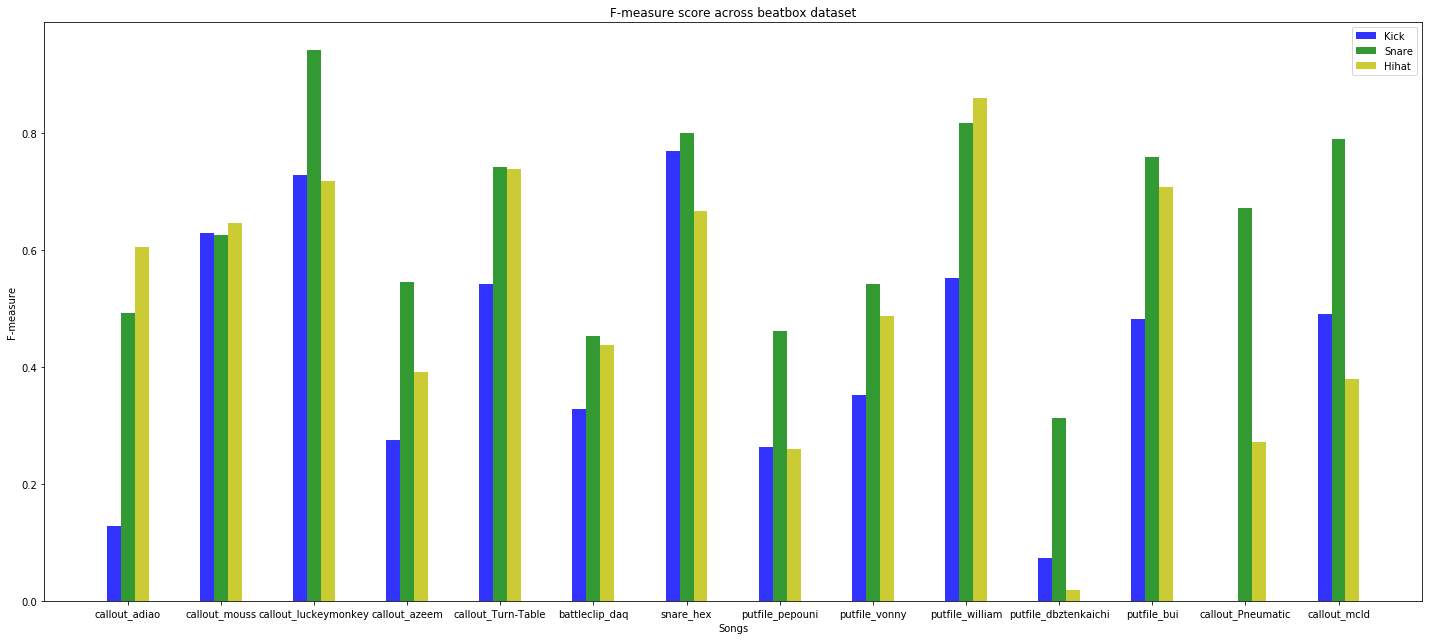

In [65]:
n_groups = 14

means_Kick = list_Kick
means_Snare = list_Snare
means_Hihat = list_Hihat

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.15
opacity = 0.8
 
rects1 = plt.bar(index, means_Kick, bar_width, alpha=opacity, color='b', label='Kick')
rects2 = plt.bar(index + bar_width, means_Snare, bar_width, alpha=opacity, color='g', label='Snare')
rects3 = plt.bar(index + 0.3, means_Hihat, bar_width, alpha=opacity, color='y', label='Hihat')

plt.xlabel('Songs')
plt.ylabel('F-measure')
plt.xticks(index + bar_width, filenames)
plt.legend()
plt.title('F-measure score across beatbox dataset')
plt.tight_layout()
plt.rcParams["figure.figsize"] = [20,9]
plt.show()

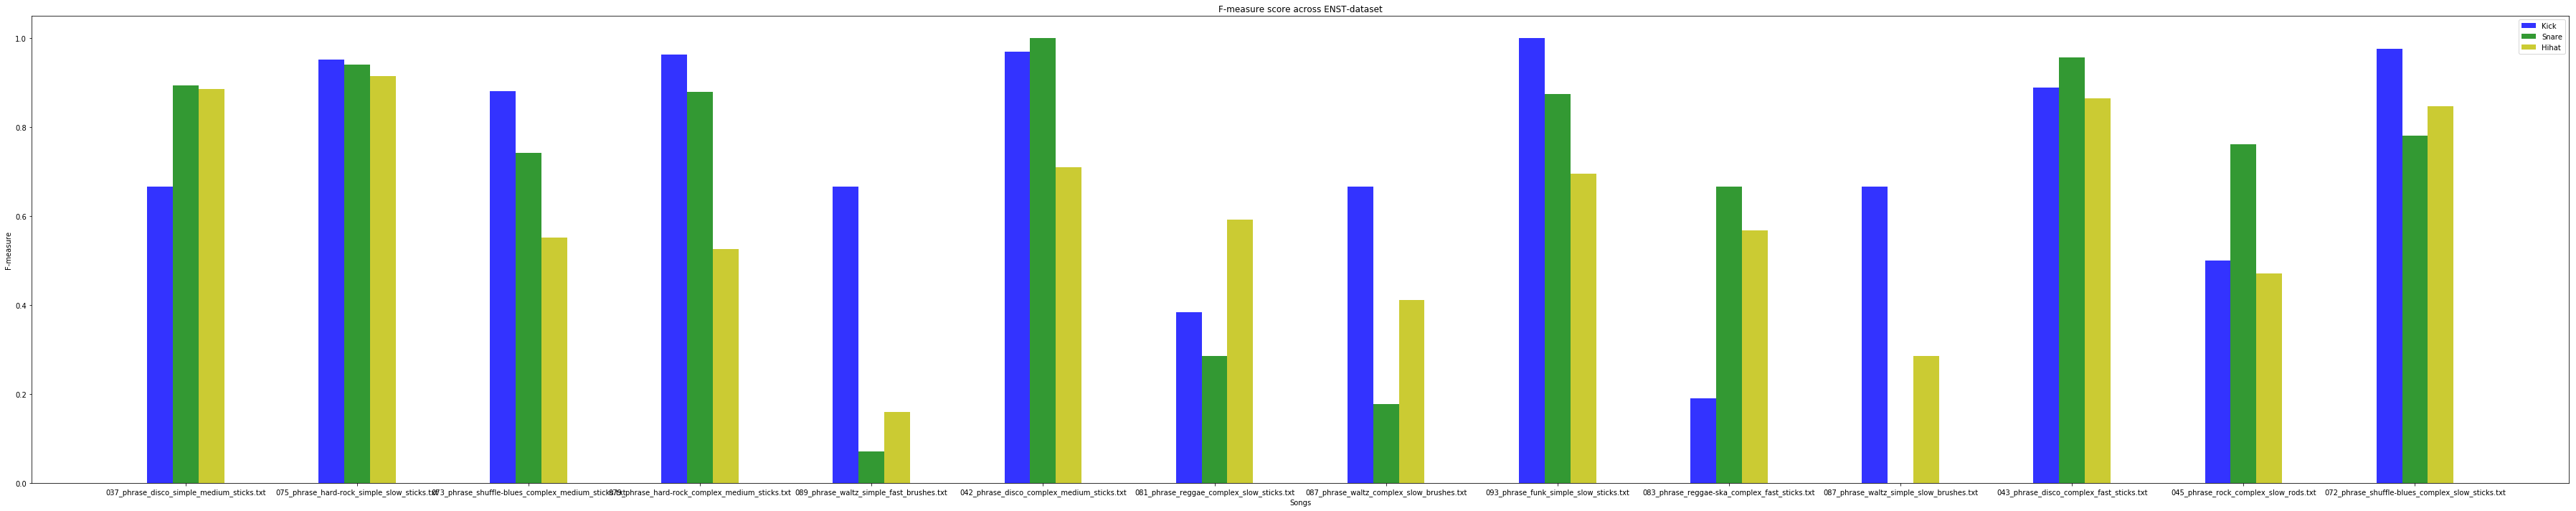

In [63]:
n_groups = 14

means_Kick = list_Kick_enst
means_Snare = list_Snare_enst
means_Hihat = list_Hihat_enst

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.15
opacity = 0.8
 
rects1 = plt.bar(index, means_Kick, bar_width, alpha=opacity, color='b', label='Kick')
rects2 = plt.bar(index + bar_width, means_Snare, bar_width, alpha=opacity, color='g', label='Snare')
rects3 = plt.bar(index + 0.3, means_Hihat, bar_width, alpha=opacity, color='y', label='Hihat')

plt.xlabel('Songs')
plt.ylabel('F-measure')
plt.xticks(index + bar_width, filenames_enst)
plt.legend()
plt.title('F-measure score across ENST-dataset')
plt.tight_layout()
plt.rcParams["figure.figsize"] = [50,10]
plt.show()

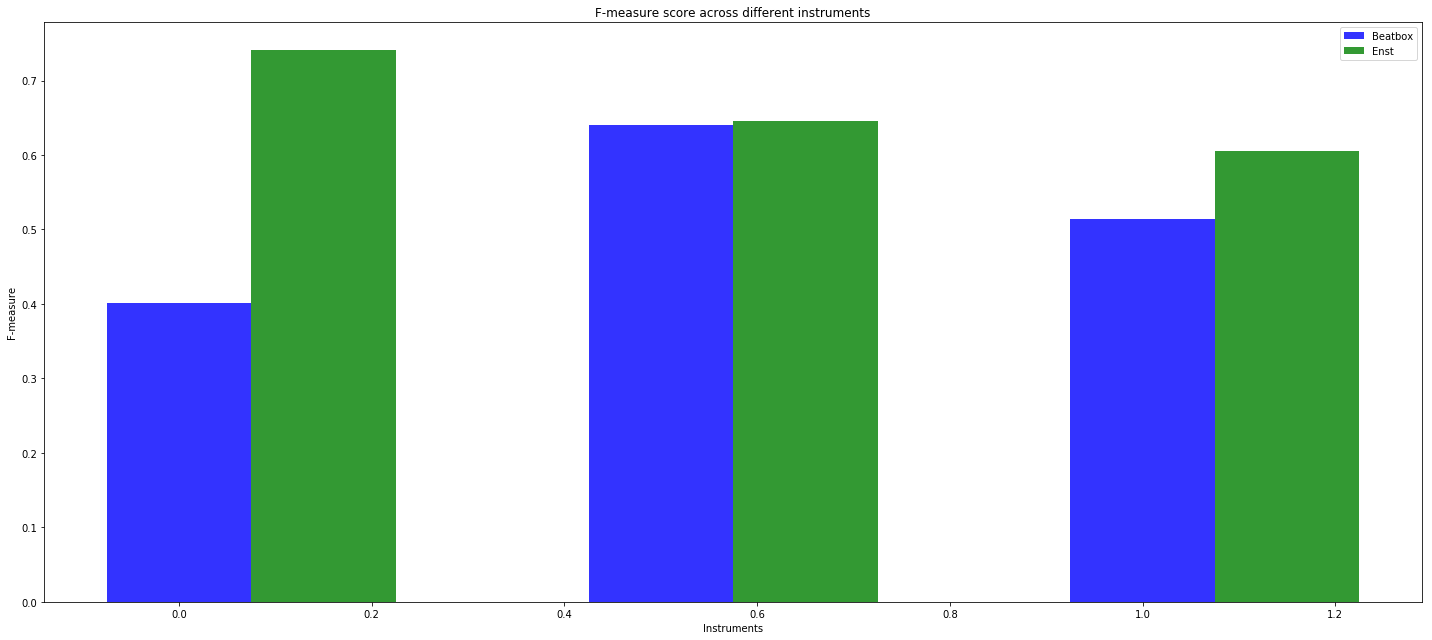

In [66]:
def mean(l):
    return sum(l) / float(len(l))

means_Kick = mean(list_Kick)
means_Snare = mean(list_Snare)
means_Hihat = mean(list_Hihat)
means_Kick_enst = mean(list_Kick_enst)
means_Snare_enst = mean(list_Snare_enst)
means_Hihat_enst = mean(list_Hihat_enst)

fig, ax = plt.subplots()
index = np.arange(1)
bar_width = 0.15
opacity = 0.8
space = 0.5
 
rects1 = plt.bar(index, means_Kick, bar_width, alpha=opacity, color='b', label='Beatbox')
rects2 = plt.bar(index + bar_width, means_Kick_enst, bar_width, alpha=opacity, color='g', label='Enst')
rects3 = plt.bar(index + space, means_Snare, bar_width, alpha=opacity, color='b')
rects4 = plt.bar(index + space + bar_width, means_Snare_enst, bar_width, alpha=opacity, color='g')
rects5 = plt.bar(index + space + space, means_Hihat, bar_width, alpha=opacity, color='b')
rects6 = plt.bar(index + space +  space + bar_width, means_Hihat_enst, bar_width, alpha=opacity, color='g')

plt.xlabel('Instruments')
plt.ylabel('F-measure')
plt.legend()
plt.title('F-measure score across different instruments')
plt.tight_layout()
plt.rcParams["figure.figsize"] = [10,5]
plt.show()

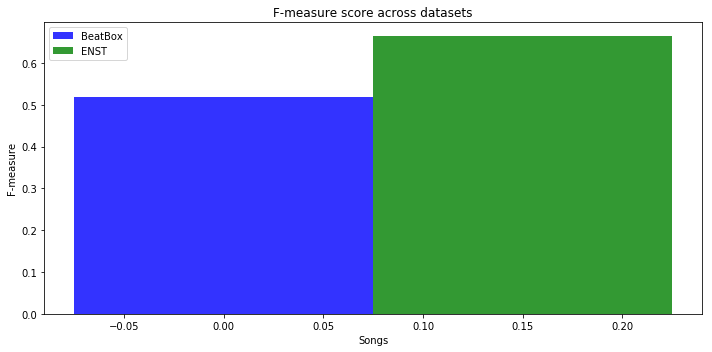

In [67]:
mean_beatbox = (means_Kick + means_Snare + means_Hihat)/3
mean_enst = (means_Kick_enst + means_Snare_enst + means_Hihat_enst)/3

fig, ax = plt.subplots()
index = np.arange(1)
bar_width = 0.15
opacity = 0.8
 
rects1 = plt.bar(index, mean_beatbox, bar_width, alpha=opacity, color='b', label='BeatBox')
rects2 = plt.bar(index + bar_width, mean_enst, bar_width, alpha=opacity, color='g', label='ENST')

plt.xlabel('Songs')
plt.ylabel('F-measure')
plt.legend()
plt.title('F-measure score across datasets')
plt.tight_layout()
plt.rcParams["figure.figsize"] = [20,9]
plt.show()